# Playground to implement W&B as well as start hyperparameter-tuning

# WanDB

In [127]:
#%pip install wandb

In [113]:
import subprocess
import wandb
from wandb.keras import WandbCallback
import tensorflow as tf
import os

In [173]:
subprocess.call(['wandb', 'login', '4e8d3dcb1584ad129b3b49ccc34f65b20116ae54'])

0

In [ ]:
wandb.init(project='precursor_charge_prediction_new')

## Setup

In [ ]:
#%pip install seaborn

In [4]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import wandb
from wandb.keras import WandbCallback
import keras

In [5]:
train_datapath = ["data/"+file for file in os.listdir('data') if file.endswith(".parquet")][0]
batch_size = 32

# Dataset batches + split

In [6]:
import re
# the dictionary
aa_syntax_dictionary = dict()
for index, i in enumerate(list('XACDEFGHIKLMNPQRSTVWY')): # added X for 0 value
    aa_syntax_dictionary[i] = index * 100
    if i != 'X': # ignore 0 value for X
        for count in range(0, 100):
            aa_syntax_dictionary[i + "[UNIMOD:" + str(count) + "]"] = index * 100 + count

def seq_translator(sequence, dictionary=aa_syntax_dictionary, print_result=False):
    """
    Translates a sequence into a vector of integers
    :param sequence: string
    :param dictionary: dictionary
    :return: list
    """
    pattern = r'[A-Z]\[[^\]]*\]|.' # regex pattern to match amino acids and modifications

    result = [match for match in re.findall(pattern, sequence)]

    if print_result:
        print(result)
    # Fill the list with "X" characters until it reaches a length of 40
    result += ['X'] * (50 - len(result))

    return [dictionary[aa] for aa in result]


def one_hot_precursor(int_value, charges=[2,3,4]):
    """
    One-hot encodes the precursor charge
    :param df: dataframe
    :param max_charge_included: int
    :return: dataframe
    """
    one_hot = [1 if x == int_value else 0 for x in charges]

    return one_hot

In [7]:
print(seq_translator('AAC[UNIMOD:4]LLVAW', print_result=True))
print(one_hot_precursor(2))

['A', 'A', 'C[UNIMOD:4]', 'L', 'L', 'V', 'A', 'W']
[100, 100, 204, 1000, 1000, 1800, 100, 1900, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0]


In [8]:
file_list = ["data/"+file for file in os.listdir('data') if file.endswith('.parquet')]
print(file_list[0])

data/Thermo_SRM_Pool_meta_data.parquet


### import parquet files, drop all columns we dont need for training, one-hot encode precursor charge, translate sequence

In [10]:
batches_parquet = dict()
counter = 0
for file in file_list:
    df = pd.read_parquet(file, engine='fastparquet')
    # drop all columns we dont need for training
    for column in df.columns:
        if column not in ["modified_sequence","precursor_intensity", "precursor_charge"]:
            df.drop(column, axis=1, inplace=True)
    charge_ranges = [1, 2, 3, 4, 5, 6] # TODO SET RANGES
    df = df[df["precursor_charge"].isin(charge_ranges)] # remove 7+ charge states // only take charge states 2,3,4
    df = df.dropna(subset=['precursor_intensity']) # drop rows with no precursor intensity
    batches_parquet[file] = df
    counter += 1
    if counter > 1:
        break # TODO REMOVE BREAK FOR FIRST FILE IN LIST

In [11]:
num_classes = len(charge_ranges)
class_names = charge_ranges

In [12]:
batches_parquet[file_list[0]].head()

,modified_sequence,precursor_charge,precursor_intensity
0,LPGSLETYVEQEQGENANDR,2,29525630.0
1,HGSLQEYLQNDTGSK,2,13188580.0
2,VEEEEEINSELTAR,2,20663460.0
3,LPGSLETYVEQEQGENANDR,2,19884630.0
4,NSSTAEINETTTSSTDFLAR,2,12804420.0


In [13]:
batches_parquet[file_list[0]]["precursor_charge"].value_counts()

2    4331294
3    1523398
4     115577
5       2723
1       1022
6        143
Name: precursor_charge, dtype: int64

# Dataset preprocessing

In [16]:
import numpy as np
# Find most frequent precursor charge
def most_frequent(List):
    unique, counts = np.unique(List, return_counts=True)
    index = np.argmax(counts)
    return unique[index]

In [17]:
def get_most_abundant(df_charge_list, df_intensity_list, debug=False):
    # Get the index of the most abundant precursor intensity
    charge_dict = dict()
    for index, i in enumerate(df_charge_list):
        if i not in charge_dict:
            charge_dict[i] = df_intensity_list[index]
        else:
            charge_dict[i] += df_intensity_list[index]
    if debug:
        print(charge_dict)
    return max(charge_dict, key=charge_dict.get)


In [18]:
# proof of concept
list_a = [1,2,1,2,1,2,1,2,1,2]
list_b = [111,21,311,41,51,611111,71,81,91111111,1011]
print("most abundant: ", get_most_abundant(list_a, list_b, True))

{1: 91111655, 2: 612265}
most abundant:  1


In [19]:
# Grouping by "modified_sequence" and aggregating precursor_charge into a list
grouped_df = batches_parquet[file_list[0]].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()

for index, row in grouped_df.iterrows():
    grouped_df.at[index, "precursor_charge"] = get_most_abundant(row["precursor_charge"], row["precursor_intensity"])
grouped_df["modified_sequence_vector"] = grouped_df["modified_sequence"].apply(seq_translator)
grouped_df["precursor_charge"] = grouped_df["precursor_charge"].apply(one_hot_precursor, args=(charge_ranges,))
grouped_df.rename(columns={"precursor_charge": "most_abundant_charge_vector"}, inplace=True)
grouped_df = grouped_df.drop("precursor_intensity", axis=1)
grouped_df = grouped_df.drop("modified_sequence", axis=1)
grouped_df

C:\Users\micro\AppData\Local\Temp\ipykernel_12040\3742099937.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_df = batches_parquet[file_list[0]].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()


,most_abundant_charge_vector,modified_sequence_vector
0,"[0, 1, 0, 0, 0, 0]","[100, 100, 100, 100, 1600, 100, 100, 400, 100,..."
1,"[0, 1, 0, 0, 0, 0]","[100, 100, 100, 204, 500, 500, 400, 1400, 1300..."
2,"[0, 1, 0, 0, 0, 0]","[100, 100, 100, 300, 500, 100, 1700, 700, 600,..."
3,"[0, 1, 0, 0, 0, 0]","[100, 100, 100, 300, 1000, 1100, 100, 2000, 20..."
4,"[0, 0, 1, 0, 0, 0]","[100, 100, 100, 300, 1600, 300, 1300, 1200, 10..."
...,...,...
70440,"[0, 1, 0, 0, 0, 0]","[2000, 2000, 1800, 2000, 1900, 2000, 1400, 140..."
70441,"[0, 1, 0, 0, 0, 0]","[2000, 2000, 2000, 400, 1200, 1600, 300, 1400,..."
70442,"[0, 0, 1, 0, 0, 0]","[2000, 2000, 2000, 600, 700, 2000, 1000, 300, ..."
70443,"[0, 1, 0, 0, 0, 0]","[2000, 2000, 2000, 1600, 300, 1200, 500, 500, ..."


In [46]:
main_ds = np.array(grouped_df["modified_sequence_vector"]) # to list
main_ds_labels = np.array(grouped_df['most_abundant_charge_vector'])

# Create an instance of StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
train_indicies, val_indicies = next(sss.split(main_ds, main_ds_labels))
train_ds, train_ds_labels = main_ds[train_indicies], main_ds_labels[train_indicies]
val_ds, val_ds_labels = main_ds[val_indicies], main_ds_labels[val_indicies]


charges = [1,2,3,4,5,6] # TODO SELECT CLASSES
num_classes = len(charges)


### Model

In [51]:
train_ds = [np.reshape(np.array(x), (1, 50, 1)) for x in train_ds]
val_ds = [np.reshape(np.array(x), (1, 50, 1)) for x in val_ds]

In [52]:
train_ds[0]

array([[[ 300],
        [2000],
        [ 800],
        [1200],
        [ 600],
        [1600],
        [1000],
        [1000],
        [ 400],
        [ 100],
        [1000],
        [ 900],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0]]])

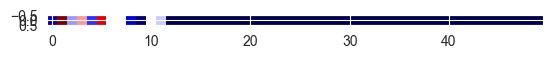

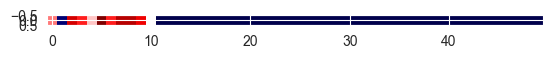

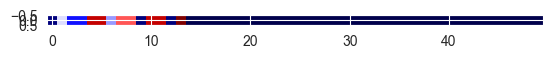

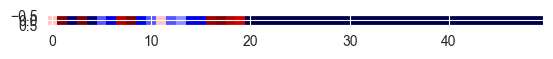

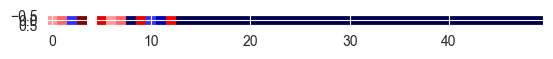

In [54]:
from matplotlib import pyplot as plt
for i in range(5):
    plt.imshow(train_ds[i], interpolation='nearest', cmap='seismic') # TODO CUSTOM COLORS FOR AA
    plt.show()

In [56]:
train_ds = tf.convert_to_tensor(train_ds)
val_ds = tf.convert_to_tensor(val_ds)

In [86]:
train_ds_labels = [np.array(x) for x in train_ds_labels]
val_ds_labels = [np.array(x) for x in val_ds_labels]

In [96]:
train_ds_labels = tf.convert_to_tensor(train_ds_labels)
val_ds_labels = tf.convert_to_tensor(val_ds_labels)

In [106]:
from keras import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Input, concatenate, Rescaling
# define two sets of inputs
inputA = Input(shape=train_ds.shape[1:])
# the first branch operates on the first input
x = Model(inputs=inputA, outputs=inputA)
# the second branch operates on the second input
y = Rescaling(scale=1./100)(inputA) # for dictionary of 2000 words (X = 0, aa 1-20 in 100 steps)
#y = Embedding(input_dim=2000, output_dim=3, input_length=50)(inputB)
y = Conv2D(filters=8000, kernel_size=(1,3), strides=1, activation="relu", padding='same')(y)
#y = MaxPooling2D(pool_size=(1,2), padding='same')(y)
#y = Conv2D(filters=128, kernel_size=(1,3), strides=1, activation="relu", padding='same')(y)
#y = MaxPooling2D(pool_size=(1,2), padding='same')(y)
y = Flatten()(y)
#y = Dense(2000, activation="relu")(y)
# combine the output of the two branches
#z = Flatten()(combined)
z = Dense(num_classes, activation="softmax")(y)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input], outputs=z)

In [105]:
model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 1, 50, 1)]        0         
                                                                 
 rescaling_11 (Rescaling)    (None, 1, 50, 1)          0         
                                                                 
 conv2d_14 (Conv2D)          (None, 1, 50, 8000)       32000     
                                                                 
 flatten_6 (Flatten)         (None, 400000)            0         
                                                                 
 dense_12 (Dense)            (None, 6)                 2400006   
                                                                 
Total params: 2,432,006
Trainable params: 2,432,006
Non-trainable params: 0
_________________________________________________________________


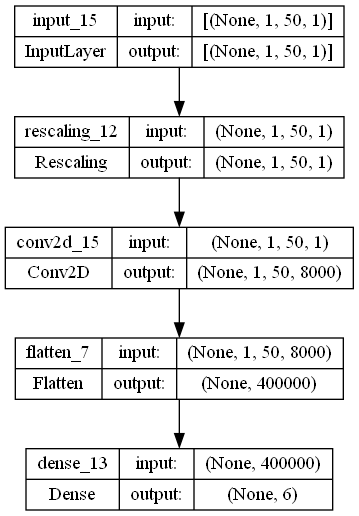

In [107]:
# plot model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [108]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [109]:
checkpoint_callback = ModelCheckpoint('precursor_charge_prediction_model_v1/cce_wo7_allSequences.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
#steps_per_epoch = train_ds_b.shape[0] // 256

In [117]:
# Train the model
# X_train, X_test, y_train, y_test
history = model.fit(train_ds, train_ds_labels, epochs=30, batch_size=4096, validation_data=(val_ds, val_ds_labels), callbacks=[checkpoint_callback, early_stopping, WandbCallback()]) #WandbCallback()

Epoch 1/30
14/14 [==============================] - 64s 5s/step - loss: 0.8670 - accuracy: 0.6280 - val_loss: 0.7059 - val_accuracy: 0.6986
Epoch 2/30
14/14 [==============================] - 63s 5s/step - loss: 0.6675 - accuracy: 0.6995 - val_loss: 0.6501 - val_accuracy: 0.7024
Epoch 3/30
14/14 [==============================] - 62s 4s/step - loss: 0.6382 - accuracy: 0.7082 - val_loss: 0.6367 - val_accuracy: 0.7115
Epoch 4/30
14/14 [==============================] - 63s 5s/step - loss: 0.6278 - accuracy: 0.7106 - val_loss: 0.6314 - val_accuracy: 0.7103
Epoch 5/30
14/14 [==============================] - 62s 4s/step - loss: 0.6216 - accuracy: 0.7115 - val_loss: 0.6264 - val_accuracy: 0.7126
Epoch 6/30
14/14 [==============================] - 63s 5s/step - loss: 0.6178 - accuracy: 0.7118 - val_loss: 0.6233 - val_accuracy: 0.7111
Epoch 7/30
14/14 [==============================] - 63s 5s/step - loss: 0.6155 - accuracy: 0.7128 - val_loss: 0.6239 - val_accuracy: 0.7052
Epoch 8/30
14/14 [==

KeyboardInterrupt: 

In [ ]:
# Access the loss, validation loss, and accuracy from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the loss, validation loss, and accuracy curves
epochs = range(1, len(loss) + 1)

# Create subplots
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot loss and validation loss
ax1.plot(epochs, loss, 'b', label='Training Loss')
ax1.plot(epochs, val_loss, 'r', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracy and validation accuracy
ax2.plot(epochs, accuracy, 'b', label='Training Accuracy')
ax2.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
model.save('precursor_charge_prediction_conv2d_model/big_conv2d_model.h5')

# Embedding model test:

In [118]:
main_ds_embed = np.array(grouped_df["modified_sequence_vector"]) # to list
main_ds_labels_embed = np.array(grouped_df['most_abundant_charge_vector'])

# Create an instance of StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
train_indicies_embed, val_indicies_embed = next(sss.split(main_ds_embed, main_ds_labels_embed))
train_ds_embed, train_ds_labels_embed = main_ds_embed[train_indicies_embed], main_ds_labels_embed[train_indicies]
val_ds_embed, val_ds_labels_embed = main_ds_embed[val_indicies_embed], main_ds_labels_embed[val_indicies_embed]


charges = [1,2,3,4,5,6] # TODO SELECT CLASSES
num_classes = len(charges)


In [120]:
train_ds_embed  = [np.array(x) for x in train_ds_embed]
val_ds_embed = [np.array(x) for x in val_ds_embed]

In [121]:
train_ds_labels_embed = [np.array(x) for x in train_ds_labels_embed]
val_ds_labels_embed = [np.array(x) for x in val_ds_labels_embed]

In [129]:
train_ds_embed = tf.convert_to_tensor(train_ds_embed)
val_ds_embed = tf.convert_to_tensor(val_ds_embed)
train_ds_labels_embed = tf.convert_to_tensor(train_ds_labels_embed)
val_ds_labels_embed = tf.convert_to_tensor(val_ds_labels_embed)

In [150]:
train_ds_embed[0]

<tf.Tensor: shape=(50,), dtype=int32, numpy=
array([ 300, 2000,  800, 1200,  600, 1600, 1000, 1000,  400,  100, 1000,
        900,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])>

In [166]:
from keras import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Input, concatenate, Rescaling
# define two sets of inputs
inputA_embed = Input(shape=train_ds_embed[0].shape)
# the first branch operates on the first input
x = Model(inputs=inputA_embed, outputs=inputA_embed)
# the second branch operates on the second input
y = Embedding(input_dim=5000, output_dim=50, input_length=50)(inputA_embed)
#y = Embedding(input_dim=2000, output_dim=3, input_length=50)(inputB)
#y = MaxPooling2D(pool_size=(1,2), padding='same')(y)
#y = Conv2D(filters=128, kernel_size=(1,3), strides=1, activation="relu", padding='same')(y)
#y = MaxPooling2D(pool_size=(1,2), padding='same')(y)
y = Flatten()(y)
y = Dense(64, activation="relu")(y)
# combine the output of the two branches
#z = Flatten()(combined)
z = Dense(num_classes, activation="softmax")(y)
# our model will accept the inputs of the two branches and
# then output a single value
model_embed = Model(inputs=[x.input], outputs=z)

In [158]:
model_embed.summary()

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 50)]              0         
                                                                 
 embedding_6 (Embedding)     (None, 50, 3)             3         
                                                                 
 flatten_14 (Flatten)        (None, 150)               0         
                                                                 
 dense_26 (Dense)            (None, 64)                9664      
                                                                 
 dense_27 (Dense)            (None, 6)                 390       
                                                                 
Total params: 10,057
Trainable params: 10,057
Non-trainable params: 0
_________________________________________________________________


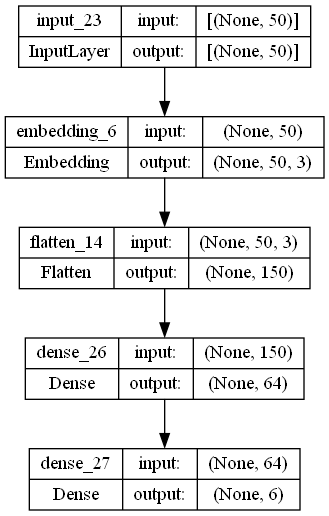

In [159]:
# plot model
tf.keras.utils.plot_model(model_embed, show_shapes=True, show_layer_names=True)

In [171]:
# Compile the model
model_embed.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [172]:
# Train the model
# X_train, X_test, y_train, y_test
history_embed = model_embed.fit(train_ds_embed, train_ds_labels_embed, epochs=150, batch_size=4096, validation_data=(val_ds_embed, val_ds_labels_embed), callbacks=[checkpoint_callback, early_stopping, WandbCallback()]) #WandbCallback()

Error: You must call wandb.init() before WandbCallback()

# Inference

In [34]:
inf_model = tf.keras.models.load_model('precursor_charge_prediction_conv2d_model/model_1_test.h5')

OSError: No file or directory found at precursor_charge_prediction_conv2d_model/model_1_test.h5

In [ ]:
# Make validation data
sample_df_inf = batches_parquet[file_list[1]][["precursor_charge", "precursor_intensity", "modified_sequence_vector"]].copy()

In [ ]:
# Split the data into train, validation, and test sets
sample_df_inf["precursor_intensity"] = sample_df_inf["precursor_intensity"].astype(int) # TODO or times 10 -> 0.1 = 1 .astype(int)
main_ds_inf = np.array(sample_df_inf[["precursor_intensity", "modified_sequence_vector"]]) # to list
main_ds_labels_inf = np.array(sample_df_inf['precursor_charge'])
max_len_inf = max(sample_df_inf.loc[:, 'modified_sequence_vector'].apply(len))  # Find the maximum length

charges = [2,3,4] # TODO SELECT CLASSES
num_classes = len(charges)

main_ds_labels_inf = np.array([one_hot_precursor(i, charges = charges) for i in main_ds_labels_inf])

In [ ]:
main_ds_inf_a, main_ds_inf_b = main_ds_inf[:, 0], main_ds_inf[:, 1:]

In [ ]:
main_ds_inf_a = main_ds_inf_a.reshape(main_ds_inf_a.shape[0], 1)
main_ds_inf_a = tf.convert_to_tensor(main_ds_inf_a, dtype=tf.int32)

main_ds_inf_b = [np.reshape(np.array(x[0]), (1, 50, 1)) for x in main_ds_inf_b]

In [ ]:
from matplotlib import pyplot as plt
for i in range(5):
    plt.imshow(main_ds_inf_b[i], interpolation='nearest', cmap='seismic') # TODO CUSTOM COLORS FOR AA
    plt.show()

In [ ]:
main_ds_inf_b[0].shape

In [ ]:
def batch_generator(X, Y, batch_size = 64):
    complete_batches = []
    x1, x2 = X
    indices = np.arange(len(x1))
    x1_array = []
    x2_array = []
    y_array = []
    for index, i in enumerate(x1):

        x1_array.append(i)
        x2_array.append(x2[index])
        y_array.append(Y[index])
        if len(x1_array)==batch_size:
            yield [x1_array, x2_array], y_array
            complete_batches.append([x1_array, x2_array], y_array)
            x1_array = []
            x2_array = []
            y_array = []
    return complete_batches


In [ ]:
train_generator = batch_generator([main_ds_inf_a, main_ds_inf_b], main_ds_labels_inf, batch_size = 32)
for batch in train_generator:
    intensities = tf.convert_to_tensor(batch[0][0], dtype=tf.int32)
    sequences = tf.convert_to_tensor(batch[0][1], dtype=tf.int32)
    labels = np.array(batch[1], dtype=np.float32)
    print(intensities)
    print(sequences)

    yhat = inf_model.predict([intensities, sequences], labels, epochs=10)
    #eval_prec.update_state(labels , yhat)
    #eval_rec.update_state(labels, yhat)
    #eval_acc.update_state(labels, yhat)

In [ ]:
print(f'Precision: {eval_prec.result().numpy()}, Recall: {eval_rec.result().numpy()}, Accuracy: {eval_acc.result().numpy()}')

In [ ]:
from tensorflow.keras import preprocessing
from tensorflow.keras import backend as K
from tensorflow.keras import models
from PIL import Image
import matplotlib.pyplot as plt
import textwrap
from matplotlib import cm
import tensorflow as tf
import numpy as np


for layerpos in range(len(model.layers)-1):
    try:
        image_size = general_image_size

        # Load pre-trained Keras model and the image to classify TODO VERIFY
        img_tensor = labeled
        img_tensor = np.expand_dims(img_tensor, axis=0)

        select_layer = model.layers[layerpos].name #was -4
        print(select_layer)
        conv_layer = model.get_layer(select_layer)
        heatmap_model = models.Model([model.inputs], [conv_layer.output, model.output])

        heatmaps_generated = set()
        heatmap_list = []
        for pndex, value in enumerate(predictions[0]):
            with tf.GradientTape() as gtape:
                conv_output, predictions = heatmap_model(img_tensor)
                loss = predictions[0][pndex]
                grads = gtape.gradient(loss, conv_output)
                pooled_grads = K.mean(grads, axis=(0, 1, 2))

            heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
            heatmap = np.maximum(heatmap, 0)
            max_heat = np.max(heatmap)
            if max_heat == 0:
                max_heat = 1e-10
            heatmap /= max_heat
            heatmaps_generated.add(heatmap.shape)
            heatmap_list.append(heatmap)
        print(heatmaps_generated)

        images_hm = []
        titles_hm = []
        predictions_hm = []

        for i in range(num_classes):
            # predictions
            prediction_value = (predictions[0][i])
            predictions_hm.append(prediction_value)

            # titles
            title = class_names[i]
            titles_hm.append(title)

            # images
            hm=np.squeeze(heatmap_list[i])

            current_img = (asarray(hm))
            sm = cm.ScalarMappable(cmap='seismic')
            sm.set_clim(current_img.min(), current_img.max())
            current_img = sm.to_rgba(current_img)
            current_img = current_img*255
            current_img = current_img.astype(np.uint8)
            current_img = cv2.cvtColor(current_img, cv2.COLOR_BGRA2BGR )
            images_hm.append(current_img)

        # plot them
        #print(len(images_hm))
        plot_image_grid(images_hm, titles_hm, predictions_hm, layername=select_layer)
    except:
        print("error", layerpos, end=" ")


# IGNORE FROM HERE

## Check in with Franzi's group for reporting

### Multilable Model
#### WIP in precursor_charge_predictor

## Model Testing
### check if models only predict charge 2 or also other charges. Due to 'overrepresentation' the best bet for the model could be to only output charge state 2

## Hyperparameter Tuning

# Inference

In [35]:
batches_parquet[file_list[1]]["precursor_charge"].value_counts()

2    1401912
3     787278
4     220159
5      34381
1      26371
6       4417
Name: precursor_charge, dtype: int64

In [36]:
last_model = keras.models.load_model('precursor_charge_prediction_model_cce_alpha/cce_wo7_allSequences.h5')

OSError: No file or directory found at precursor_charge_prediction_model_cce_alpha/cce_wo7_allSequences.h5

In [ ]:
batches_parquet.keys()

In [ ]:
# Make validation data
inference_df = batches_parquet[file_list[1]][["precursor_charge", "modified_sequence_vector", "precursor_intensity"]].copy()

In [ ]:
inference_df.head(4)

In [ ]:
[len(i) for i in inference_df["modified_sequence_vector"] if len(i) != 50]

In [ ]:
inference_df = inference_df[inference_df['modified_sequence_vector'].apply(lambda x: len(x) <= 50)]

In [37]:
[len(i) for i in inference_df["modified_sequence_vector"] if len(i) != 50]

NameError: name 'inference_df' is not defined

In [ ]:
[i for i in inference_df["precursor_charge"] if i not in [2,3,4]]

In [ ]:
[i for i in inference_df["precursor_intensity"] if i > 1000000000000]

In [ ]:
inference_df

In [38]:
inference_df[list(range(0, 50))] = pd.DataFrame(inference_df["modified_sequence_vector"].tolist(), index= inference_df.index)

NameError: name 'inference_df' is not defined

In [ ]:
inference_df.drop("modified_sequence_vector", axis=1, inplace=True)

In [ ]:
inference_df.head(4)

In [ ]:
inference_ds = tf.convert_to_tensor(inference_df)

In [ ]:
inference_target = inference_ds[:, 0]
inference_features = inference_ds[:, 1:]

In [ ]:
inference_target_labels =  np.array([one_hot_precursor(i, charges=charge_ranges) for i in inference_target])

In [ ]:
results = model_cce.evaluate(inference_features, inference_target_labels, batch_size=256)
print("test loss, test acc:", results)

## Evaluate the models
- confusion matrix
- accuracy
- loss

Confusion Matrix

In [39]:
import sklearn
matrix = sklearn.metrics.confusion_matrix(train_ds_labels.argmax(axis=1), inference_target_labels.argmax(axis=1))

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
#!pip install scikit-learn
#!pip install numpy --upgrade
#!pip install pandas --upgrade
#!pip install matplotlib --upgrade
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
#do_predictions = model.predict(test_ds)

y_pred = []
y_true = []

# iterate over the dataset
for index, i in enumerate(inference_ds):   # use dataset.unbatch() with repeat
   print(inference_target_labels[index])
   print(inference_features[index])
   # append true labels
   y_true.append(inference_target_labels[index])
   # compute predictions
   preds = model_cce.predict(inference_features[index])
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = -1))
# convert the true and predicted labels into tensors
true_labels = tf.cast(tf.concat([item for item in y_true], axis = 0), tf.float32)
predicted_labels = tf.cast(tf.concat([item for item in y_pred], axis = 0), tf.float32)


cm = confusion_matrix(true_labels, predicted_labels)
#print(cm)
report = classification_report(true_labels,predicted_labels, target_names=class_names)

report_dict = classification_report(true_labels, predicted_labels, output_dict=True)
#print(report_dict)
print(report)

#pd.DataFrame(report_dict).transpose()


Accuracy/ Sens/ Spec

In [40]:
import keras.backend as K
def matthews_correlation(y_true, y_pred):
    #print(y_pred.shape, y_true.shape)
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(K.cast(y_pos * y_pred_pos, 'float32'))
    tn = K.sum(K.cast(y_neg * y_pred_neg, 'float32'))
    fp = K.sum(K.cast(y_neg * y_pred_pos, 'float32'))
    fn = K.sum(K.cast(y_pos * y_pred_neg, 'float32'))

    print("OVERALL:")
    print(" Accuracy ", ((tp + tn) / (tp + tn + fp + fn)).numpy())
    print(" Sensitivity ", (tp / (tp + fn)).numpy())
    print(" Specificity ", (tn / (tn + fp)).numpy())

    numerator = (tp * tn - fp * fn)
    #print(tp.numpy(), fp.numpy())
    test = (((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
    #print(test)
    denominator = K.sqrt(K.cast(test, 'float32'))

    return numerator / (denominator + K.epsilon())


#print(true_labels, predicted_labels)
print(" matthews_correlation(rounded): ", (matthews_correlation(true_labels, predicted_labels).numpy()))

NameError: name 'true_labels' is not defined

MCC

In [41]:
from sklearn.metrics import matthews_corrcoef

print("matthews_correlation:", matthews_corrcoef(true_labels, predicted_labels))

NameError: name 'true_labels' is not defined

Direct eval:

In [42]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

eval_prec = Precision()
eval_rec = Recall()
eval_acc = BinaryAccuracy()

In [43]:
for batch in test_ds.as_numpy_iterator():
    X, y = batch
    y = tf.keras.utils.to_categorical(y, num_classes=13, dtype='int')
    yhat = model.predict(X)
    eval_prec.update_state(y, yhat)
    eval_rec.update_state(y, yhat)
    eval_acc.update_state(y, yhat)

NameError: name 'test_ds' is not defined

In [ ]:
print(f'Precision: {eval_prec.result().numpy()}, Recall: {eval_rec.result().numpy()}, Accuracy: {eval_acc.result().numpy()}')